In [1]:
##############################################################################################################
# DESCRIPTION: 
# RESULTS:     
#              
##############################################################################################################

In [2]:
######################
# CONFIG & HYPERPARAMS
######################

import os

class HyperParams:
    pass

IMG_PATH = "C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/"

IMG_PATH_VALID = IMG_PATH + "validation/"
IMG_PATH_TEST = IMG_PATH + "test/"
IMG_PATH_TRAIN = IMG_PATH

IMG_PATH_TRAIN = IMG_PATH

hyperparams = HyperParams()
hyperparams.IMG_WIDTH = 64
hyperparams.IMG_HEIGHT = 64
hyperparams.EPOCHS = 300
hyperparams.BATCH_SIZE = 16

hyperparams.NUM_CHANNELS = 32
hyperparams.NUM_RES_BLOCKS = 5

hyperparams.LOSS = 'mean_absolute_error'

IMG_WIDTH = hyperparams.IMG_WIDTH
IMG_HEIGHT = hyperparams.IMG_HEIGHT

IMG_CASE = str(IMG_WIDTH) +  "/0001_0100"
MODEL_NAME = "0001_0100-64-resnet-xxh"

DEST_TESTS = os.path.abspath(os.path.join('../../../out_tests/', MODEL_NAME))

class RadianceLimits:
    pass
radiance_limits = RadianceLimits()
radiance_limits.noisy_min = 0
radiance_limits.noisy_max = 0.0174
radiance_limits.nitid_min = 0
radiance_limits.nitid_max = 0.8130

from tensorflow.keras.optimizers import Nadam
hyperparams.OPTIMIZER = Nadam(learning_rate=0.0001)

In [3]:
##################
# IMPORTS
##################

import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

import numpy as np
import tensorflow 
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)
import os, sys
module_path = os.path.abspath(os.path.join('../../support/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import DatasetUtilsTifF as dsutils
import TrainModelD as train
import ReportsK as reports
import ResnetBatchE as model_factory

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

print(f"Tensorflow version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6252298774533981017
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5722079232
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18276546316977658462
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.6"
]
Tensorflow version: 2.6.0
Keras Version: 2.6.0
GPU is available


In [5]:
##################
# MODEL DEFINITION
##################

model = model_factory.buildModel(hyperparams)
model.summary()
model.optimizer.get_config()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   3200        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 64, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

{'name': 'Nadam',
 'learning_rate': 0.0001,
 'decay': 0.004,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07}

In [6]:
##################
# PREPARE DATA
##################

train_noisy_files, train_nitid_files, train_noisy, train_nitid = dsutils.readDataset( IMG_PATH_TRAIN, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT, radiance_limits)
val_noisy_files, val_nitid_files, val_noisy, val_nitid = dsutils.readDataset( IMG_PATH_VALID, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT, radiance_limits)

train_noisy, train_nitid = dsutils.reshapeDataset( train_noisy, train_nitid, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT )
val_noisy, val_nitid = dsutils.reshapeDataset( val_noisy, val_nitid, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT)

Read dataset. Path: C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/
Noisy files:8086
Nitid files:8086
Read dataset. Path: C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/validation/
Noisy files:2000
Nitid files:2000


In [7]:
##################
# TRAIN MODEL
##################
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

checkpoint_filepath = os.path.abspath(os.path.join('../../../saves/') + MODEL_NAME \
                                      + "_checkpoint_" + '_weights_{epoch:02d}-{val_loss:.2f}')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

hist = train.fit( model, hyperparams, train_noisy, train_nitid, val_noisy, val_nitid, patience = 50, \
                 callbacks=[model_checkpoint_callback] )

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.6

Epoch 1/300
506/506 [==============================] - 84s 141ms/step - loss: 0.3205 - val_loss: 0.0640
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0001_0100-64-resnet-xxh_checkpoint__weights_01-0.06\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/300
506/506 [==============================] - 71s 139ms/step - loss: 0.0607 - val_loss: 0.0613
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0001_0100-64-resnet-xxh_checkpoint__weights_02-0.06\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/300
506/506 [==============================] - 71s 139ms/step - loss: 0.0505 - val_loss: 0.0575
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0001_0100-64-resnet-xxh_checkpoint__weights_03-0.06\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/300
506/506 [==============================] - 71s 139ms/step - loss: 0.0464 - val_loss: 0.0514
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0001_0100-64-resnet-xxh_checkpoint__weights_04-0.05\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/300
506/506 [==============================] - 70s 139ms/step - loss: 0.0437 - val_loss: 0.0501
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0001_0100-64-resnet-xxh_checkpoint__weights_05-0.05\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 6/300
506/506 [==============================] - 70s 139ms/step - loss: 0.0420 - val_loss: 0.0492
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0001_0100-64-resnet-xxh_checkpoint__weights_06-0.05\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 7/300
506/506 [==============================] - 71s 139ms/step - loss: 0.0408 - val_loss: 0.0467
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0001_0100-64-resnet-xxh_checkpoint__weights_07-0.05\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 8/300
506/506 [==============================] - 70s 137ms/step - loss: 0.0397 - val_loss: 0.0491
Epoch 9/300
506/506 [==============================] - 70s 138ms/step - loss: 0.0390 - val_loss: 0.0468
Epoch 10/300
506/506 [==============================] - 70s 139ms/step - loss: 0.0386 - val_loss: 0.0473
Epoch 11/300
506/506 [==============================] - 70s 139ms/step - loss: 0.0382 - val_loss: 0.0443
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0001_0100-64-resnet-xxh_checkpoint__weights_11-0.04\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 12/300
506/506 [==============================] - 71s 141ms/step - loss: 0.0378 - val_loss: 0.0465
Epoch 13/300
506/506 [==============================] - 71s 140ms/step - loss: 0.0375 - val_loss: 0.0457
Epoch 14/300
506/506 [==============================] - 71s 141ms/step - loss: 0.0372 - val_loss: 0.0441
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0001_0100-64-resnet-xxh_checkpoint__weights_14-0.04\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 15/300
506/506 [==============================] - 72s 141ms/step - loss: 0.0369 - val_loss: 0.0455
Epoch 16/300
506/506 [==============================] - 71s 141ms/step - loss: 0.0367 - val_loss: 0.0459
Epoch 17/300
506/506 [==============================] - 71s 141ms/step - loss: 0.0364 - val_loss: 0.0444
Epoch 18/300
506/506 [==============================] - 71s 140ms/step - loss: 0.0362 - val_loss: 0.0439
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0001_0100-64-resnet-xxh_checkpoint__weights_18-0.04\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 19/300
506/506 [==============================] - 71s 140ms/step - loss: 0.0360 - val_loss: 0.0432
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0001_0100-64-resnet-xxh_checkpoint__weights_19-0.04\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 20/300
506/506 [==============================] - 71s 141ms/step - loss: 0.0359 - val_loss: 0.0427
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0001_0100-64-resnet-xxh_checkpoint__weights_20-0.04\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 21/300
506/506 [==============================] - 71s 139ms/step - loss: 0.0358 - val_loss: 0.0439
Epoch 22/300
506/506 [==============================] - 71s 141ms/step - loss: 0.0355 - val_loss: 0.0432
Epoch 23/300
506/506 [==============================] - 70s 139ms/step - loss: 0.0355 - val_loss: 0.0429
Epoch 24/300
506/506 [==============================] - 70s 139ms/step - loss: 0.0354 - val_loss: 0.0470
Epoch 25/300
506/506 [==============================] - 70s 138ms/step - loss: 0.0353 - val_loss: 0.0430
Epoch 26/300
506/506 [==============================] - 71s 141ms/step - loss: 0.0353 - val_loss: 0.0430
Epoch 27/300
506/506 [==============================] - 70s 139ms/step - loss: 0.0350 - val_loss: 0.0444
Epoch 28/300
506/506 [==============================] - 71s 140ms/step - loss: 0.0349 - val_loss: 0.0435
Epoch 29/300
506/506 [==============================] - 71s 139ms/step - loss: 0.0349 - val_loss: 0.0435
Epoch 30/300
506/506 [==============================] -

C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 33/300
506/506 [==============================] - 71s 141ms/step - loss: 0.0346 - val_loss: 0.0419
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0001_0100-64-resnet-xxh_checkpoint__weights_33-0.04\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 34/300
506/506 [==============================] - 72s 141ms/step - loss: 0.0346 - val_loss: 0.0430
Epoch 35/300
506/506 [==============================] - 71s 141ms/step - loss: 0.0345 - val_loss: 0.0434
Epoch 36/300
506/506 [==============================] - 71s 141ms/step - loss: 0.0345 - val_loss: 0.0442
Epoch 37/300
506/506 [==============================] - 71s 141ms/step - loss: 0.0344 - val_loss: 0.0432
Epoch 38/300
506/506 [==============================] - 71s 141ms/step - loss: 0.0343 - val_loss: 0.0435
Epoch 39/300
506/506 [==============================] - 71s 141ms/step - loss: 0.0343 - val_loss: 0.0424
Epoch 40/300
506/506 [==============================] - 71s 140ms/step - loss: 0.0343 - val_loss: 0.0431
Epoch 41/300
506/506 [==============================] - 71s 139ms/step - loss: 0.0341 - val_loss: 0.0420
Epoch 42/300
506/506 [==============================] - 71s 140ms/step - loss: 0.0341 - val_loss: 0.0420
Epoch 43/300
506/506 [==============================] -

C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 61/300
506/506 [==============================] - 71s 140ms/step - loss: 0.0336 - val_loss: 0.0416
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0001_0100-64-resnet-xxh_checkpoint__weights_61-0.04\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 62/300
506/506 [==============================] - 71s 141ms/step - loss: 0.0336 - val_loss: 0.0436
Epoch 63/300
506/506 [==============================] - 71s 140ms/step - loss: 0.0336 - val_loss: 0.0430
Epoch 64/300
506/506 [==============================] - 71s 140ms/step - loss: 0.0336 - val_loss: 0.0447
Epoch 65/300
506/506 [==============================] - 71s 140ms/step - loss: 0.0336 - val_loss: 0.0428
Epoch 66/300
506/506 [==============================] - 71s 140ms/step - loss: 0.0334 - val_loss: 0.0416
Epoch 67/300
506/506 [==============================] - 71s 140ms/step - loss: 0.0335 - val_loss: 0.0410
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0001_0100-64-resnet-xxh_checkpoint__weights_67-0.04\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 68/300
506/506 [==============================] - 71s 140ms/step - loss: 0.0336 - val_loss: 0.0418
Epoch 69/300
506/506 [==============================] - 71s 140ms/step - loss: 0.0334 - val_loss: 0.0428
Epoch 70/300
506/506 [==============================] - 71s 140ms/step - loss: 0.0335 - val_loss: 0.0431
Epoch 71/300
506/506 [==============================] - 71s 141ms/step - loss: 0.0334 - val_loss: 0.0423
Epoch 72/300
506/506 [==============================] - 71s 140ms/step - loss: 0.0335 - val_loss: 0.0428
Epoch 73/300
506/506 [==============================] - 71s 140ms/step - loss: 0.0334 - val_loss: 0.0434
Epoch 74/300
506/506 [==============================] - 71s 140ms/step - loss: 0.0334 - val_loss: 0.0416
Epoch 75/300
506/506 [==============================] - 71s 141ms/step - loss: 0.0334 - val_loss: 0.0426
Epoch 76/300
506/506 [==============================] - 71s 140ms/step - loss: 0.0334 - val_loss: 0.0444
Epoch 77/300
506/506 [==============================] -

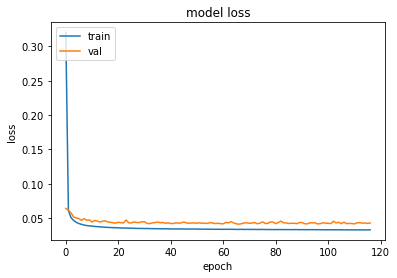

Best Epoch:67


In [8]:
##################
# REPORTS
##################
reports.plotHistory( hist )

In [9]:
model.save(os.path.abspath(os.path.join('../../../saves/', MODEL_NAME)), model)

INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0001_0100-64-resnet-xxh\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [10]:
##################
# PREDICTIONS
##################
ACCURACY_THRESHOLD = 0.01
predictions_metrics, predictions_headers \
    = reports.calcPredictionMetrics( model, val_noisy, val_nitid, ACCURACY_THRESHOLD, \
                                    save_pred = True, save_path = DEST_TESTS, \
                                    noisy_files = val_noisy_files, nitid_files = val_nitid_files, \
                                    max_nitid= radiance_limits.nitid_max  )

Images count =2000
Best RMSENZ  =1946 (0.97)
Best MAENZ   =1893 (0.95)
Best PSNR    =1946 (0.97)
Best Accuracy=1697 (0.85)
RMSE-NZ  Pred=0.0498  Noisy=0.1151
MAE-NZ   Pred=0.0412  Noisy=0.0945
PSNR     Pred=11.9 dB Noisy=5.1 dB
Accuracy Pred=0.29    Noisy=0.12
SSM      Pred=0.85    Noisy=0.30
HOG MSE  Pred=0.09    Noisy=0.15


In [11]:
reports.saveMetrics( DEST_TESTS, MODEL_NAME, predictions_headers, predictions_metrics )

Read dataset. Path: C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test/
Noisy files:15
Nitid files:15
Index:0
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0025_06_00_0_noisy_idx068.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0025_06_00_0_nitid_idx076.tif


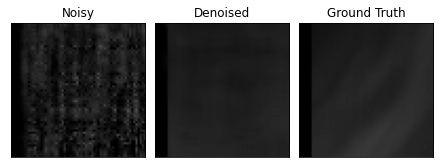

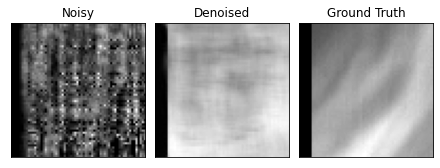

RMSE-NZ  Pred=0.0320  Noisy=0.0762 BEST
MAE-NZ   Pred=0.0245  Noisy=0.0607 BEST
PSNR     Pred=16.8 dB Noisy=9.3 dB BEST
Accuracy Pred=0.31    Noisy=0.11 BEST
SSM      Pred=0.92    Noisy=0.41
HOG MSE  Pred=0.08    Noisy=0.15
******************************************************
Index:1
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0025_07_00_9_noisy_idx068.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0025_07_00_9_nitid_idx076.tif


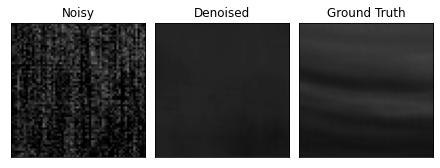

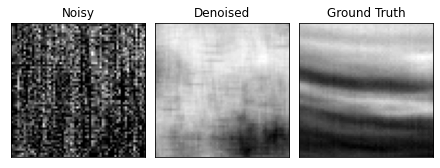

RMSE-NZ  Pred=0.0496  Noisy=0.1043 BEST
MAE-NZ   Pred=0.0411  Noisy=0.0869 BEST
PSNR     Pred=14.1 dB Noisy=7.7 dB BEST
Accuracy Pred=0.14    Noisy=0.06 BEST
SSM      Pred=0.91    Noisy=0.12
HOG MSE  Pred=0.32    Noisy=0.22
******************************************************
Index:2
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0025_07_01_11_noisy_idx089.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0025_07_01_11_nitid_idx076.tif


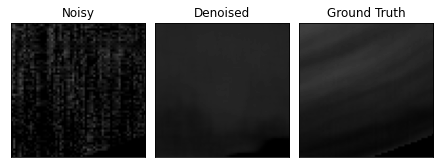

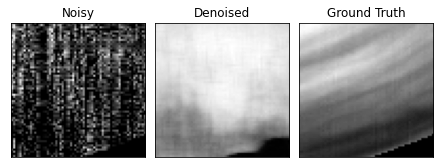

RMSE-NZ  Pred=0.0387  Noisy=0.0960 BEST
MAE-NZ   Pred=0.0310  Noisy=0.0800 BEST
PSNR     Pred=16.3 dB Noisy=8.4 dB BEST
Accuracy Pred=0.22    Noisy=0.06 BEST
SSM      Pred=0.86    Noisy=0.21
HOG MSE  Pred=0.13    Noisy=0.21
******************************************************
Index:3
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0025_07_01_2_noisy_idx089.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0025_07_01_2_nitid_idx076.tif


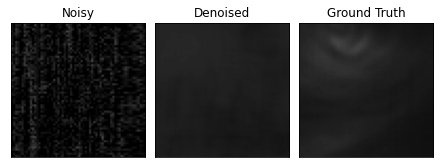

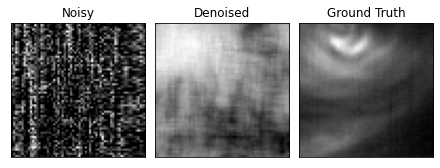

RMSE-NZ  Pred=0.0260  Noisy=0.0938 BEST
MAE-NZ   Pred=0.0200  Noisy=0.0805 BEST
PSNR     Pred=20.3 dB Noisy=9.1 dB BEST
Accuracy Pred=0.31    Noisy=0.06 BEST
SSM      Pred=0.92    Noisy=0.19
HOG MSE  Pred=0.12    Noisy=0.11
******************************************************
Index:4
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0361_04_00_15_noisy_idx068.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0361_04_00_15_nitid_idx076.tif


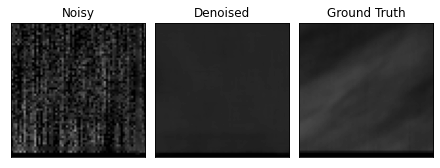

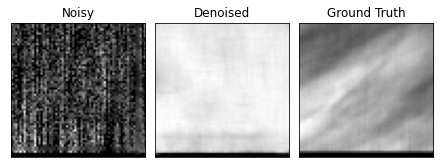

RMSE-NZ  Pred=0.0542  Noisy=0.1126 BEST
MAE-NZ   Pred=0.0461  Noisy=0.0917 BEST
PSNR     Pred=14.5 dB Noisy=8.1 dB BEST
Accuracy Pred=0.11    Noisy=0.07 BEST
SSM      Pred=0.84    Noisy=0.14
HOG MSE  Pred=0.06    Noisy=0.27
******************************************************
Index:5
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0361_04_01_7_noisy_idx089.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0361_04_01_7_nitid_idx076.tif


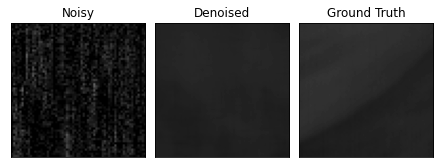

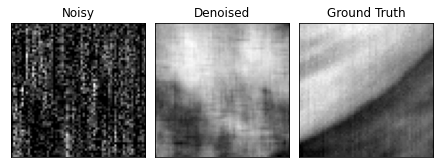

RMSE-NZ  Pred=0.0346  Noisy=0.1147 BEST
MAE-NZ   Pred=0.0278  Noisy=0.1006 BEST
PSNR     Pred=15.6 dB Noisy=5.2 dB BEST
Accuracy Pred=0.26    Noisy=0.05 BEST
SSM      Pred=0.92    Noisy=0.16
HOG MSE  Pred=0.15    Noisy=0.19
******************************************************
Index:6
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0362_04_01_15_noisy_idx089.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0362_04_01_15_nitid_idx076.tif


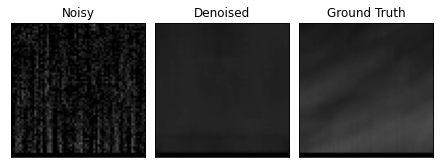

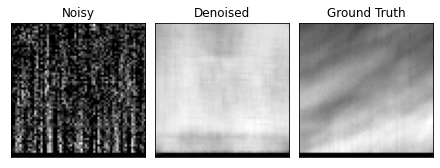

RMSE-NZ  Pred=0.0670  Noisy=0.1357 BEST
MAE-NZ   Pred=0.0504  Noisy=0.1172 BEST
PSNR     Pred=12.8 dB Noisy=6.6 dB BEST
Accuracy Pred=0.19    Noisy=0.04 BEST
SSM      Pred=0.87    Noisy=0.18
HOG MSE  Pred=0.05    Noisy=0.25
******************************************************
Index:7
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0363_00_00_0_noisy_idx068.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0363_00_00_0_nitid_idx076.tif


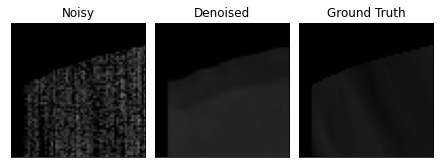

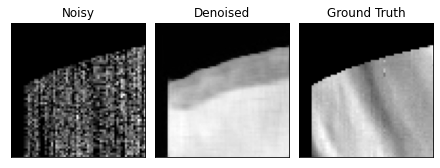

RMSE-NZ  Pred=0.0438  Noisy=0.1015 BEST
MAE-NZ   Pred=0.0326  Noisy=0.0807 BEST
PSNR     Pred=8.5 dB Noisy=1.2 dB BEST
Accuracy Pred=0.39    Noisy=0.10 BEST
SSM      Pred=0.87    Noisy=0.44
HOG MSE  Pred=0.11    Noisy=0.08
******************************************************
Index:8
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0567_01_01_8_noisy_idx089.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0567_01_01_8_nitid_idx076.tif


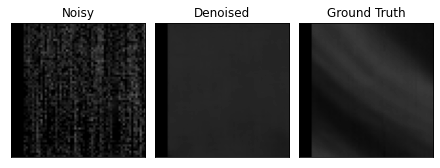

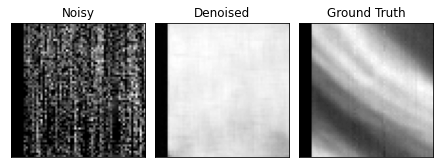

RMSE-NZ  Pred=0.0501  Noisy=0.0960 BEST
MAE-NZ   Pred=0.0419  Noisy=0.0792 BEST
PSNR     Pred=13.2 dB Noisy=7.5 dB BEST
Accuracy Pred=0.17    Noisy=0.07 BEST
SSM      Pred=0.81    Noisy=0.22
HOG MSE  Pred=0.13    Noisy=0.20
******************************************************
Index:9
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0567_02_01_9_noisy_idx089.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0567_02_01_9_nitid_idx076.tif


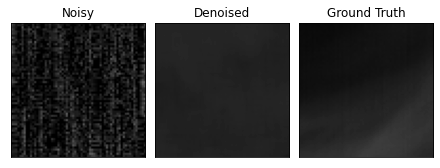

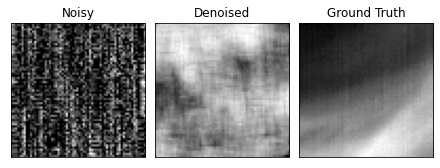

RMSE-NZ  Pred=0.0587  Noisy=0.0971 BEST
MAE-NZ   Pred=0.0503  Noisy=0.0798 BEST
PSNR     Pred=12.4 dB Noisy=8.0 dB BEST
Accuracy Pred=0.12    Noisy=0.07 BEST
SSM      Pred=0.81    Noisy=0.14
HOG MSE  Pred=0.09    Noisy=0.15
******************************************************
Index:10
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0567_03_00_9_noisy_idx068.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0567_03_00_9_nitid_idx076.tif


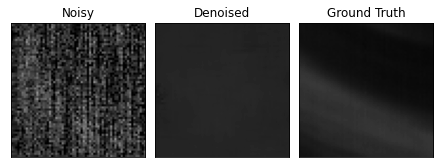

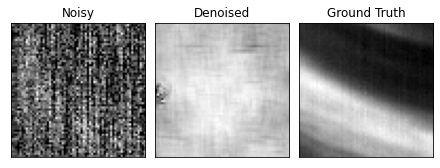

RMSE-NZ  Pred=0.0681  Noisy=0.1540 BEST
MAE-NZ   Pred=0.0608  Noisy=0.1226 BEST
PSNR     Pred=10.4 dB Noisy=3.3 dB BEST
Accuracy Pred=0.05    Noisy=0.05 WORST
SSM      Pred=0.73    Noisy=0.07
HOG MSE  Pred=0.13    Noisy=0.19
******************************************************
Index:11
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0569_02_01_11_noisy_idx089.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0569_02_01_11_nitid_idx076.tif


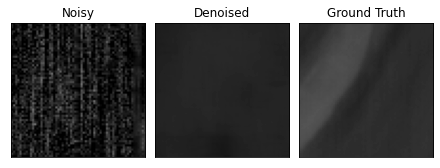

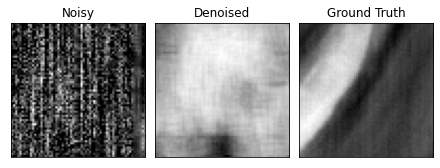

RMSE-NZ  Pred=0.0823  Noisy=0.1426 BEST
MAE-NZ   Pred=0.0658  Noisy=0.1207 BEST
PSNR     Pred=12.1 dB Noisy=7.4 dB BEST
Accuracy Pred=0.07    Noisy=0.04 BEST
SSM      Pred=0.77    Noisy=0.12
HOG MSE  Pred=0.17    Noisy=0.19
******************************************************
Index:12
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0571_02_01_10_noisy_idx089.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0571_02_01_10_nitid_idx076.tif


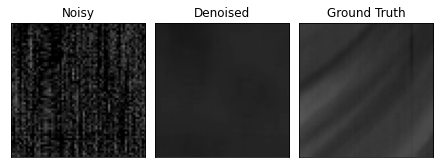

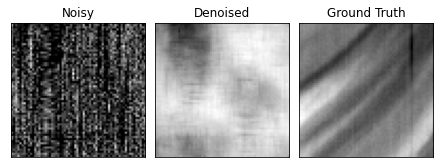

RMSE-NZ  Pred=0.0800  Noisy=0.1416 BEST
MAE-NZ   Pred=0.0705  Noisy=0.1219 BEST
PSNR     Pred=12.5 dB Noisy=7.5 dB BEST
Accuracy Pred=0.04    Noisy=0.04 BEST
SSM      Pred=0.75    Noisy=0.12
HOG MSE  Pred=0.22    Noisy=0.27
******************************************************
Index:13
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0571_03_00_11_noisy_idx068.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0571_03_00_11_nitid_idx076.tif


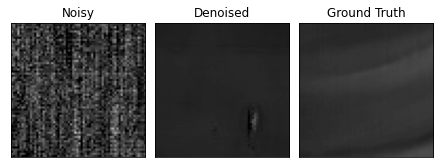

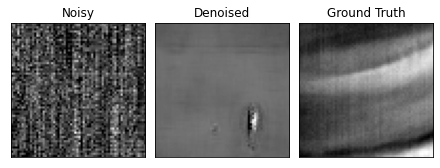

RMSE-NZ  Pred=0.0654  Noisy=0.1312 BEST
MAE-NZ   Pred=0.0576  Noisy=0.1051 BEST
PSNR     Pred=13.3 dB Noisy=7.2 dB BEST
Accuracy Pred=0.01    Noisy=0.05 WORST
SSM      Pred=0.84    Noisy=0.07
HOG MSE  Pred=0.11    Noisy=0.18
******************************************************
Index:14
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0706_02_01_3_noisy_idx089.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0706_02_01_3_nitid_idx076.tif


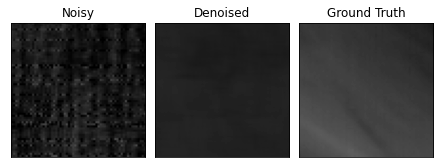

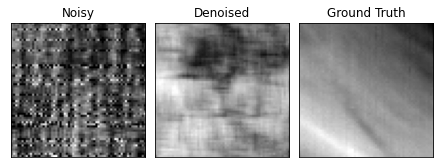

RMSE-NZ  Pred=0.1241  Noisy=0.1634 BEST
MAE-NZ   Pred=0.1167  Noisy=0.1488 BEST
PSNR     Pred=9.4 dB Noisy=7.0 dB BEST
Accuracy Pred=0.00    Noisy=0.01 WORST
SSM      Pred=0.74    Noisy=0.35
HOG MSE  Pred=0.10    Noisy=0.12
******************************************************


In [12]:
test_noisy_files, test_nitid_files, test_noisy, test_nitid = \
    dsutils.readDataset( IMG_PATH_TEST, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT, radiance_limits)

test_noisy, test_nitid = \
    dsutils.reshapeDataset( test_noisy, test_nitid,  hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT )

test_indexes = np.arange(0,test_noisy.shape[0])

reports.predictByIndexes( model, test_noisy, test_nitid, test_noisy_files, test_nitid_files, test_indexes, ACCURACY_THRESHOLD )